In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from tensorflow.keras.layers import Dense, Dropout, Bidirectional
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.optimizers import Adam, SGD, Adadelta, Adagrad, Adamax, Nadam, RMSprop
from tensorflow.keras.regularizers import l1, l2
from math import sqrt

## Import Data

In [2]:
df = pd.read_csv('../../data/merged_all_values_v2.csv')

In [3]:
df.head()

,DATETIME,TEMPERATURE,DAY,DAY_OF_WEEK,MONTH,YEAR,HOUR,MINUTE,WEEKEND,PUBLIC_HOLIDAY,TIME_OF_DAY,SEASON,TOTALDEMAND
0,1/01/2010 0:00,23.1,1,4,1,2010,0,0,0,1,1,1,8038.00
1,1/01/2010 0:30,22.9,1,4,1,2010,0,30,0,1,1,1,7809.31
2,1/01/2010 1:00,22.6,1,4,1,2010,1,0,0,1,1,1,7483.69
3,1/01/2010 1:30,22.5,1,4,1,2010,1,30,0,1,1,1,7117.23
4,1/01/2010 2:00,22.5,1,4,1,2010,2,0,0,1,1,1,6812.03


## Take Subset Of Data To Only Include Years 2017, 2018, 2019 and 2020

In [4]:
df = df[(df.YEAR == 2017) | (df.YEAR == 2018) | (df.YEAR == 2019) | (df.YEAR == 2020)]

## One Hot Encoding

Comment out any hot encoding that is not required.

Make sure to drop the original source column used to generate any one-hot encoding.

### Month

In [5]:
month = pd.get_dummies(df.MONTH, prefix='MONTH')
df = df.merge(month, left_index=True, right_index=True)

### Hour

In [6]:
hour = pd.get_dummies(df.HOUR, prefix='HOUR')
df = df.merge(hour, left_index=True, right_index=True)

### Time Of Day

In [7]:
# time_of_day = pd.get_dummies(df.TIME_OF_DAY, prefix='TIME_OF_DAY')
# df = df.merge(time_of_day, left_index=True, right_index=True)

### Season

In [8]:
# season = pd.get_dummies(df.SEASON, prefix='SEASON')
# df = df.merge(season, left_index=True, right_index=True)

### Day Of The Week

In [9]:
# day_of_week = pd.get_dummies(df.DAY_OF_WEEK, prefix='DAY_OF_WEEK')
# df = df.merge(day_of_week, left_index=True, right_index=True)

## Create Train And Test Datasets

In [10]:
train = df[df.YEAR != 2020]
test = df[df.YEAR == 2020]

## Drop Columns Not Required

In [11]:
# Fields commented out are being used so hence are not dropped. However if one-hot encoding has been used then the
# original column used to generate the one-hot encoding needs to be dropped.

train.drop(['DATETIME',
            #'TEMPERATURE',
            'DAY',
            'DAY_OF_WEEK',
            'MONTH',
            'YEAR',
            'HOUR',
            'MINUTE',
            #'WEEKEND',
            #'PUBLIC_HOLIDAY',
            'TIME_OF_DAY',
            'SEASON'], axis=1, inplace=True)
test.drop(['DATETIME',
            #'TEMPERATURE',
            'DAY',
            'DAY_OF_WEEK',
            'MONTH',
            'YEAR',
            'HOUR',
            'MINUTE',
            #'WEEKEND',
            #'PUBLIC_HOLIDAY',
            'TIME_OF_DAY',
            'SEASON'], axis=1, inplace=True)

D:\Users\Matthew\anaconda3\envs\tf2\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


## Scale Continuous Variables

Comment out any variable that is not required.

### Temperature

In [12]:
temp_transformer = MinMaxScaler(feature_range=(0, 1))
temp_transformer = temp_transformer.fit(train[['TEMPERATURE']])

train['TEMPERATURE'] = temp_transformer.transform(train[['TEMPERATURE']])
test['TEMPERATURE'] = temp_transformer.transform(test[['TEMPERATURE']])

<ipython-input-12-bc4d97359920>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['TEMPERATURE'] = temp_transformer.transform(train[['TEMPERATURE']])
<ipython-input-12-bc4d97359920>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['TEMPERATURE'] = temp_transformer.transform(test[['TEMPERATURE']])


### Total Demand

In [13]:
td_transformer = MinMaxScaler(feature_range=(0, 1))
td_transformer = td_transformer.fit(train[['TOTALDEMAND']])

train['TOTALDEMAND'] = td_transformer.transform(train[['TOTALDEMAND']])
test['TOTALDEMAND'] = td_transformer.transform(test[['TOTALDEMAND']])

<ipython-input-13-e8521410cbdd>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['TOTALDEMAND'] = td_transformer.transform(train[['TOTALDEMAND']])
<ipython-input-13-e8521410cbdd>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['TOTALDEMAND'] = td_transformer.transform(test[['TOTALDEMAND']])


## Configure Lookback Period And Apply To Train And Test Datasets

In [14]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [15]:
time_steps = 24

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train, train.TOTALDEMAND, time_steps)
X_test, y_test = create_dataset(test, test.TOTALDEMAND, time_steps)

print(X_train.shape, y_train.shape)

(52536, 24, 40) (52536,)


## Configure LSTM Neural Network

In [16]:
model = Sequential()
model.add(Bidirectional(
    LSTM(units=50, input_shape=(
        X_train.shape[1],
        X_train.shape[2]),
         activation='relu'))
         )
# model.add(Dropout(rate=0.0)) - Appears to just make things worse. May be reuired if more neurons are configured.
model.add(Dense(1))
opt = Adam()
model.compile(loss='mean_squared_error', optimizer=opt)

## Fit Model To Train Dataset

In [17]:
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.1, shuffle=True)

Epoch 1/30
1478/1478 [==============================] - 14s 10ms/step - loss: 0.0014 - val_loss: 4.6317e-04
Epoch 2/30
1478/1478 [==============================] - 14s 9ms/step - loss: 1.9855e-04 - val_loss: 2.2753e-04
Epoch 3/30
1478/1478 [==============================] - 14s 10ms/step - loss: 1.3734e-04 - val_loss: 1.4889e-04
Epoch 4/30
1478/1478 [==============================] - 14s 9ms/step - loss: 1.0736e-04 - val_loss: 2.0674e-04
Epoch 5/30
1478/1478 [==============================] - 13s 9ms/step - loss: 9.5651e-05 - val_loss: 9.9460e-05
Epoch 6/30
1478/1478 [==============================] - 14s 9ms/step - loss: 7.8396e-05 - val_loss: 1.0154e-04
Epoch 7/30
1478/1478 [==============================] - 13s 9ms/step - loss: 7.1869e-05 - val_loss: 7.6305e-05
Epoch 8/30
1478/1478 [==============================] - 14s 9ms/step - loss: 6.6292e-05 - val_loss: 6.7861e-05
Epoch 9/30
1478/1478 [==============================] - 15s 10ms/step - loss: 5.9794e-05 - val_loss: 6.2292e-05
Ep

## Plot Losses Per Epoch

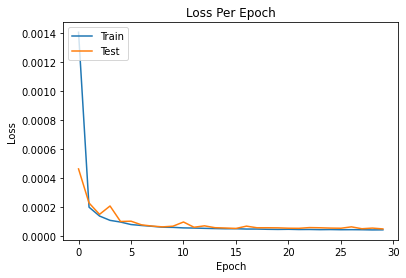

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Per Epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Make Predictions For Test And Train Dataset

In [19]:
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)

## Convert Values Back To Regular Values

In [20]:
# Typically you would not scale y values. However, as the scaled total demand values were used to create both the x and y
# values, the scaling for the prediction and y test now needs to be reversed.
y_pred = td_transformer.inverse_transform(y_pred)
y_test = td_transformer.inverse_transform([y_test])

y_pred_train = td_transformer.inverse_transform(y_pred_train)
y_train = td_transformer.inverse_transform([y_train])

## Calculate RMSE

### Test Dataset

In [21]:
y_test = y_test.reshape(-1)
y_test = pd.Series(y_test)

y_pred = y_pred.reshape(-1)
y_pred = pd.Series(y_pred)

mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
print('RMSE: %f' % rmse)

RMSE: 70.528047


### Train Dataset (for comparison with Test dataset)

In [22]:
y_train = y_train.reshape(-1)
y_train = pd.Series(y_train)

y_pred_train = y_pred_train.reshape(-1)
y_pred_train = pd.Series(y_pred_train)

mse = mean_squared_error(y_train, y_pred_train)
rmse = sqrt(mse)
print('RMSE: %f' % rmse)

RMSE: 55.465946


## Average Percentage Difference Between Prediction And Actual Values

In [23]:
predict_actual = y_test.to_frame()
predict_actual['PREDICTION'] = y_pred
predict_actual.columns = ['ACTUAL', 'PREDICTION']
predict_actual['PERCENT_DIFF'] = abs(predict_actual.ACTUAL - predict_actual.PREDICTION) / predict_actual.ACTUAL * 100

In [24]:
avg_perc_diff = sum(predict_actual.PERCENT_DIFF) / len(predict_actual)
avg_perc_diff

0.6889922684718999

In [25]:
predict_actual

,ACTUAL,PREDICTION,PERCENT_DIFF
0,6815.00,6711.944336,1.512189
1,6954.52,6795.007812,2.293648
2,7087.53,6971.105469,1.642667
3,7187.66,7156.186035,0.437889
4,7365.48,7288.362305,1.047015
...,...,...,...
17539,7072.75,7052.985840,0.279441
17540,7062.97,6989.127441,1.045489
17541,7172.60,7086.833496,1.195752
17542,7125.65,7082.728516,0.602352
